### This model combines two branches: MobileNet and Bidirectional LSTM. 

The Mobilenet branch is largely based on Beluga's kernel https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892 and the LSTM branch is inspired by Kevin's kernel, with modifications https://www.kaggle.com/kmader/quickdraw-baseline-lstm-reading-and-submission 

The performance depends on what you use for the two branches. I got up to 0.925 using this architecture. Inspired by this paper here: https://arxiv.org/abs/1804.01401
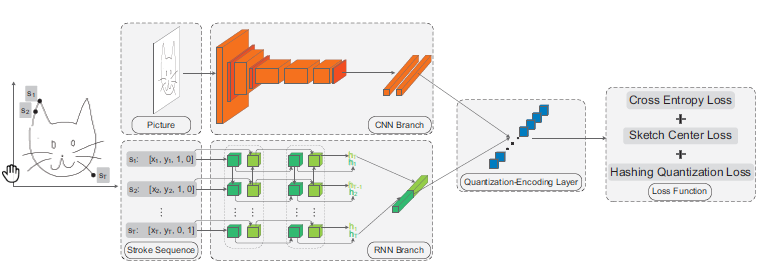

In [ ]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from ast import literal_eval
from keras.preprocessing.sequence import pad_sequences
start = dt.datetime.now()

In [ ]:

DP_DIR = '../input/shuffle-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'
BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [ ]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## MobileNet branch

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

### Change number of epochs here when you want to train. 2 epochs for illustration only. 

In [ ]:
STEPS = 800
EPOCHS = 30
size = 128
batchsize = 340

In [ ]:
base_model = MobileNet(input_shape=(size, size,3), alpha=1., weights="imagenet", include_top = False)
inp = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(NCATS, activation='softmax')(x)
model = Model(inp, x)

base_model = Sequential(model.layers[:-2])

In [ ]:
base_model.summary()

## LSTM branch

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout, Bidirectional
from keras.layers import CuDNNLSTM as LSTM # this one is about 3x faster on GPU instances
inp = Input(shape = (70,3))

x = BatchNormalization()(inp)

# # filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
x = Conv1D(256, (5,), activation = "relu")(x)
x = Dropout(0.2)(x)
x = Conv1D(256, (5,), activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Conv1D(256, (3,), activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences = False))(x)
x = Dropout(0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(NCATS, activation='softmax')(x)
stroke_read_model = Model(inp,x)
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model = Sequential(stroke_read_model.layers[:-1])
stroke_read_model.summary()

### Combining two branches

In [ ]:
inp = base_model.input
y = base_model.output
y = GlobalAveragePooling2D()(y)

inp2 = Input(shape = (70, 3))
z = stroke_read_model(inp2)
x = concatenate([y, z])
x = Dropout(0.3)(x)
x = Dense(NCATS, activation='softmax')(x)
model = Model([inp, inp2], x)

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

### LSTM Preprocessing

In [ ]:
def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=70, 
                         padding='post').swapaxes(0, 1)


## Data Generator

In [ ]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing1'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing1.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = np.repeat(x, 3, axis =3)
                x = preprocess_input(x).astype(np.float32)
                
                df['drawing'] = df['drawing'].map(_stack_it)
                x2 = np.stack(df['drawing'], 0)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield [x, x2], y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing1'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    
    for i, raw_strokes in enumerate(df.drawing1.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = np.repeat(x, 3, axis =3)
    x = preprocess_input(x).astype(np.float32)
    df['drawing'] = df['drawing'].map(_stack_it)
    x2 = np.stack(df['drawing'], 0)
    return [x,x2]

In [ ]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))
val_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1, NCSVS))

### First 20 epochs

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1),
    ModelCheckpoint("mobilenet_lstm.model",monitor='val_top_3_accuracy', 
                                   mode = 'max', save_best_only=True, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=val_datagen, validation_steps = 100,
    callbacks = callbacks
)
hists.append(hist)

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [ ]:
df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS)), nrows=34000)
for i in range(10):
    valid_df = df.loc[i*3400:(i+1)*3400,:].copy()
    x_valid, x2 = df_to_image_array_xd(valid_df, size)
    y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
    print(x_valid.shape, y_valid.shape)
    print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))
    valid_predictions = model.predict([x_valid, x2], batch_size=128, verbose=1)
    map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)

    print('Map3: {:.3f}'.format(map3))

## Create Submission

In [ ]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))

for i in range(10):
    end = min((i+1)*11220, 112199)
    subtest= test.iloc[i*11220:end].copy().reset_index(drop=True)
    x_test = df_to_image_array_xd(subtest, size)

    test_predictions = model.predict(x_test, batch_size=128, verbose=1)

    top3 = preds2catids(test_predictions)
    cats = list_all_categories()
    id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
    top3cats = top3.replace(id2cat)
    subtest['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
    subtest.head()
    if i ==0:
        submission = subtest[['key_id', 'word']]
    else: 
        submission = submission.append(subtest[['key_id', 'word']], ignore_index=True)


In [ ]:
submission.to_csv('lstm_mobilenet.csv', index=False)
submission.head()
submission.shape

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))